# Анализ эффективности кампаний

## 1. Сравните эффективность различных кампаний с точки зрения генерации лидов и коэффициента конверсии.

In [1]:
import pandas as pd

spend_df = pd.read_pickle("spend_cleaned.pkl")

In [2]:
spend_df

,Date,Source,Campaign,Impressions,Spend,Clicks,AdGroup
0,2023-07-03,google ads,gen_analyst_de,6,0.00,0,NaN
1,2023-07-03,google ads,performancemax_eng_de,4,0.01,1,NaN
2,2023-07-03,facebook ads,03.07.23women,187,3.30,6,women
3,2023-07-03,facebook ads,03.07.23women,4,0.02,1,women
4,2023-07-03,facebook ads,02.07.23wide_de,61,0.58,0,wide
...,...,...,...,...,...,...,...
16395,2024-06-21,tiktok ads,22.05.2024wide_de,7,0.03,0,wide
16396,2024-06-21,youtube ads,youtube_shorts_de,90,0.51,2,com_august
16397,2024-06-21,facebook ads,17.03.24wide_at,7,0.07,0,wide
16398,2024-06-21,tiktok ads,12.07.2023wide_de,61,0.16,0,wide


In [3]:
spend_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16400 entries, 0 to 16399
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         16400 non-null  datetime64[ns]
 1   Source       16400 non-null  category      
 2   Campaign     14204 non-null  object        
 3   Impressions  16400 non-null  int64         
 4   Spend        16400 non-null  float64       
 5   Clicks       16400 non-null  int64         
 6   AdGroup      13370 non-null  object        
dtypes: category(1), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 785.0+ KB


In [4]:
spend_df.nunique()

Date            355
Source           14
Campaign         51
Impressions    4003
Spend          2859
Clicks          552
AdGroup          24
dtype: int64

In [5]:
deals_df = pd.read_pickle("deals_cleaned.pkl")

In [6]:
# Calculate the number of deals from Deals by campaign
leads = deals_df.groupby('Campaign', observed=True)['Id'].nunique()
leads

Campaign
01.04.23women_pl          31
02.05.24test_de          121
02.07.23wide_de          974
02.08.23interests_de       8
03.07.23women            612
                        ... 
work_wr                    6
workingin_de              48
yo_de                     13
youtube_shorts_de       1624
youtube_shortsin_at       14
Name: Id, Length: 152, dtype: int64

In [7]:
# Clean up names for reliable comparison
spend_campaigns = set(spend_df['Campaign'].dropna().str.strip().unique())
deal_campaigns = set(deals_df['Campaign'].dropna().str.strip().unique())

# Campaigns that are in Spend and in Deals
matching_campaigns = spend_campaigns & deal_campaigns
print("Campaigns that match the name:", len(matching_campaigns))

Campaigns that match the name: 45


In [8]:
# Linking Campaigns to contacts
deals_with_contacts = deals_df[['Campaign', 'Contact Name']].dropna()

# Calculate the number of unique leads for each campaign
leads_per_campaign = deals_with_contacts.groupby('Campaign', observed=True)['Contact Name'].nunique().reset_index()
leads_per_campaign.columns = ['Campaign', 'Leads']
leads_per_campaign

,Campaign,Leads
0,01.04.23women_pl,31
1,02.05.24test_de,120
2,02.07.23wide_de,942
3,02.08.23interests_de,8
4,03.07.23women,600
...,...,...
145,work_wr,6
146,workingin_de,46
147,yo_de,13
148,youtube_shorts_de,1520


In [9]:
# Sum up impressions for each campaign
impressions_per_campaign = spend_df.groupby('Campaign', observed=True, as_index=False)['Impressions'].sum()

# Combine leads and impressions
merged_df = impressions_per_campaign.merge(leads_per_campaign, on='Campaign', how='left')
merged_df['Leads'] = merged_df['Leads'].fillna(0)

# Calculate conversion
merged_df['Conversion Rate (%)'] = merged_df.apply(
    lambda row: (row['Leads'] / row['Impressions'] * 100) if row['Impressions'] > 0 else None,
    axis=1
)

# Sort by conversion
merged_df_sorted = merged_df.sort_values('Conversion Rate (%)', ascending=False)

In [10]:
print(merged_df_sorted.head(10))  # top 10 conversion campaigns

                   Campaign  Impressions  Leads  Conversion Rate (%)
38                   bbo_de         3069  149.0             4.855002
40      brand_search_eng_de         7783  165.0             2.120005
39                 blog2_de        16100  273.0             1.695652
48               web2408_de         9315  143.0             1.535158
2           02.05.24test_de        20047  120.0             0.598593
18  14.11.23wide_webinar_de        18128   99.0             0.546117
12  08.06.24wide_webinar_de        20934  111.0             0.530238
44           gen_analyst_de         8852   35.0             0.395391
22             15.07.23b_de        54268  131.0             0.241395
11  08.04.24wide_webinar_de       126514  278.0             0.219739


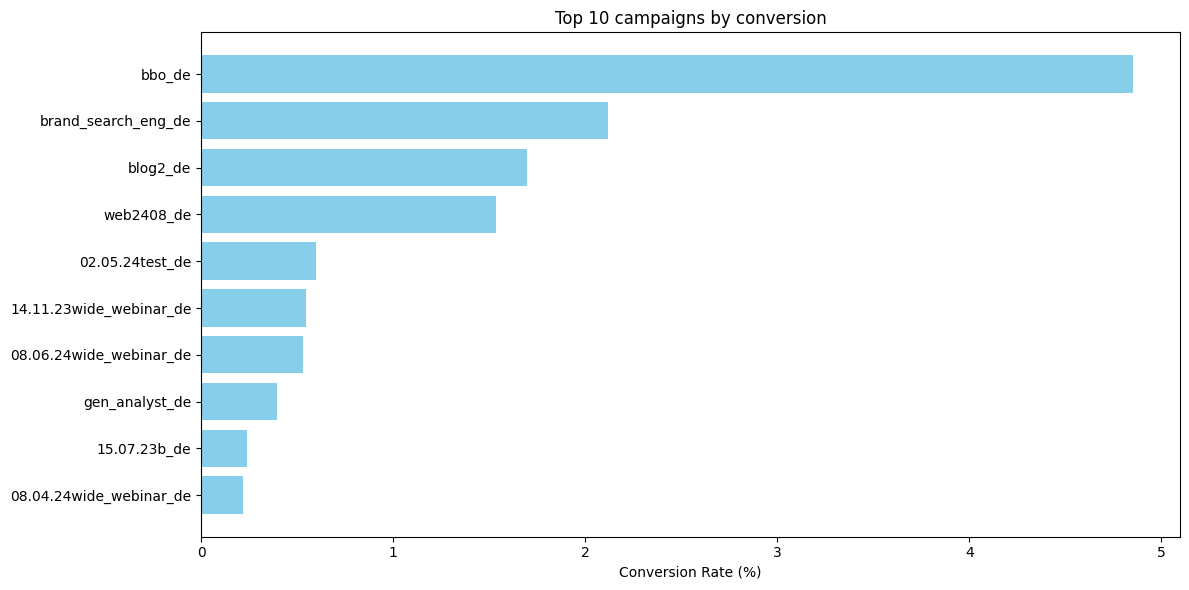

In [11]:
# visualize the top 10 campaigns by conversion on a graph
import matplotlib.pyplot as plt

top10_by_conversion = merged_df_sorted[merged_df_sorted['Conversion Rate (%)'].notna()].head(10)

plt.figure(figsize=(12,6))
plt.barh(top10_by_conversion['Campaign'], top10_by_conversion['Conversion Rate (%)'], color='skyblue')
plt.xlabel('Conversion Rate (%)')
plt.title('Top 10 campaigns by conversion')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

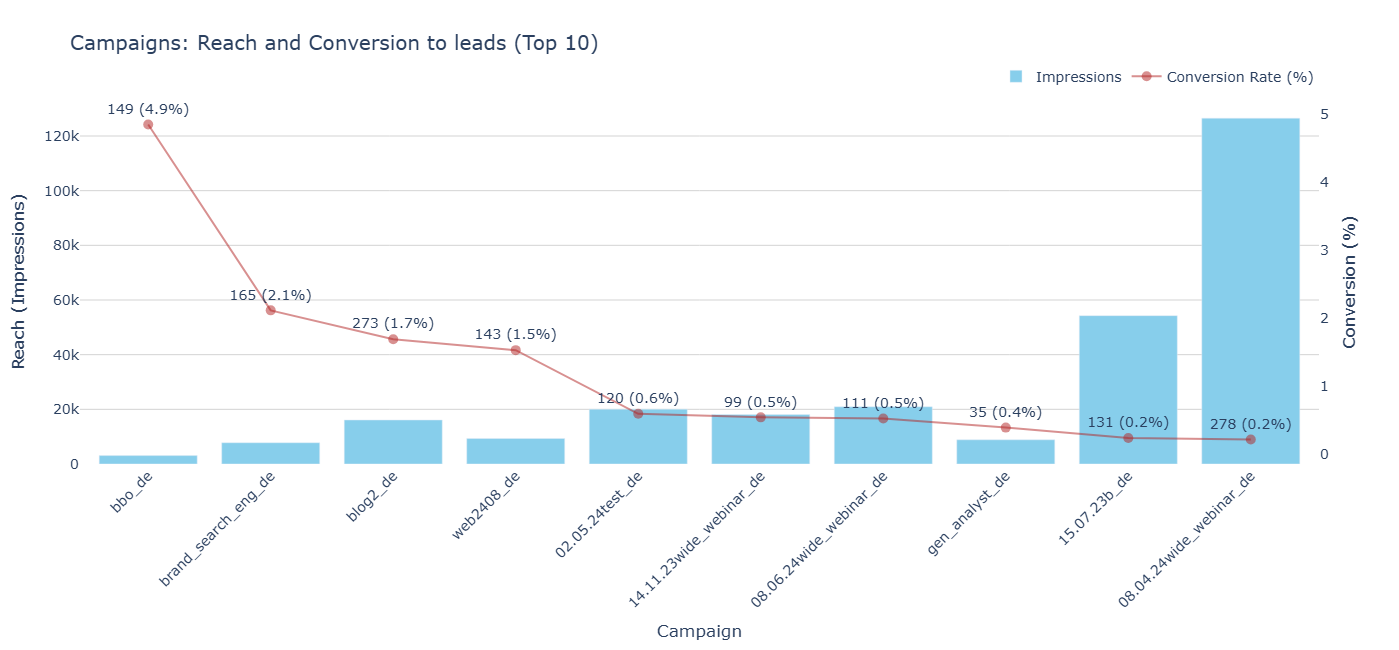

In [30]:
import plotly.graph_objects as go
import plotly.graph_objects as go

top10_lead_conv = merged_df_sorted.head(10)

# create signatures with the number of leads and conversion percentage
texts = [f"{int(leads)} ({conv:.1f}%)" for leads, conv in zip(top10_lead_conv['Leads'], top10_lead_conv['Conversion Rate (%)'])]

fig = go.Figure()

# Bar: Impressions 
fig.add_trace(go.Bar(
    x=top10_lead_conv['Campaign'],
    y=top10_lead_conv['Impressions'],
    name='Impressions',
    marker_color='skyblue',
    yaxis='y1'
))

# Line: Conversion Rate (%) 
fig.add_trace(go.Scatter(
    x=top10_lead_conv['Campaign'],
    y=top10_lead_conv['Conversion Rate (%)'],
    name='Conversion Rate (%)',
    mode='lines+markers+text',
    marker=dict(color='rgba(178,34,34,0.5)', size=10),
    line=dict(width=2, color='rgba(178,34,34,0.5)'),
    text=texts,
    textposition='top center',
    yaxis='y2'
))

fig.update_layout(
    title='Campaigns: Reach and Conversion to leads (Top 10)',
    xaxis=dict(title='Campaign', tickangle=-45, showgrid=False),
    yaxis=dict(
        title='Reach (Impressions)',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis2=dict(
        title='Conversion (%)',
        overlaying='y',
        side='right',
        showgrid=False,
        zeroline=False
    ),
    legend=dict(        
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=14),
    height=650
)

fig.show()

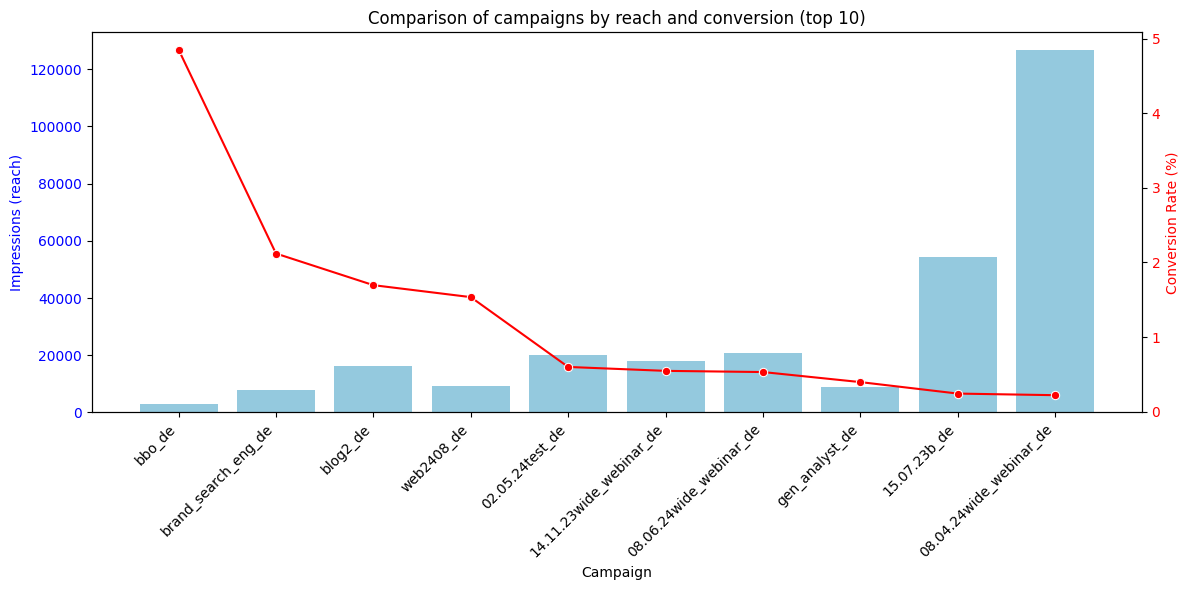

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Comparison of campaigns by reach and conversion (top 10)

fig, ax1 = plt.subplots(figsize=(12,6))

# Bar chart for Impressions
sns.barplot(x=top10_by_conversion['Campaign'], y='Impressions', data=top10_by_conversion, ax=ax1, color='skyblue')
ax1.set_ylabel('Impressions (reach)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(len(top10_by_conversion)))
ax1.set_xticklabels(top10_by_conversion['Campaign'], rotation=45, ha='right')

# Create a second Y axis for conversion
ax2 = ax1.twinx()
sns.lineplot(x=top10_by_conversion['Campaign'], y='Conversion Rate (%)', data=top10_by_conversion, ax=ax2, color='red', marker='o')
ax2.set_ylabel('Conversion Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Comparison of campaigns by reach and conversion (top 10)')
plt.tight_layout()
plt.show()

In [32]:
# filter only successful deals
successful_deals_df = deals_df[(deals_df['Stage'] == 'Payment Done') & (deals_df['Offer Total Amount'].notna())]
successful_deals_df

,Id,Deal Owner Name,Closing Date,Quality,Stage,Lost Reason,Campaign,SLA,Source,Payment Type,...,Months of study,Initial Amount Paid,Offer Total Amount,Contact Name,City,German level,Create_to_Close_Days,Latitude,Longitude,SLA_range
463,5805028000055502703,Eva Kent,2024-06-18,B - Medium,Payment Done,NaN,performancemax_wide_at,0 days 14:35:20,google ads,Recurring Payments,...,1,500.0,4500.0,5805028000055471387,Podskalie,NaN,3.0,48.1667,18.3167,Very slow (>60 min)
473,5805028000055524315,Ben Hall,2024-06-19,A - High,Payment Done,NaN,12.07.2023wide_de,0 days 00:17:25,tiktok ads,Recurring Payments,...,1,500.0,4500.0,5805028000055503302,Zinnowitz,NaN,4.0,54.0777,13.9104,Medium (15-30 min)
491,5805028000055524040,Ben Hall,2024-06-23,B - Medium,Payment Done,NaN,live_de,0 days 00:23:42,telegram posts,NaN,...,1,1000.0,9000.0,5805028000055464156,Wolfsburg,B1,8.0,52.4226,10.7865,Medium (15-30 min)
824,5805028000054664018,Ben Hall,2024-06-19,D - Non Target,Payment Done,NaN,NaN,0 days 16:31:52,organic,NaN,...,1,1000.0,9000.0,5805028000054683001,Zwickau,A2,8.0,50.7194,12.4884,Very slow (>60 min)
1029,5805028000054257317,Quincy Vincent,2024-06-17,B - Medium,Payment Done,NaN,02.07.23wide_de,0 days 00:45:55,facebook ads,NaN,...,1,1000.0,11000.0,5805028000054284461,Leinfelden-Echterdingen,B1,7.0,48.6941,9.1479,Slow (30-60 min)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21034,5805028000002302112,Julia Nelson,2023-07-19,C - Low,Payment Done,Expensive,performancemax_digitalmarkt_ru_de,0 days 15:24:52,google ads,NaN,...,2,1000.0,5000.0,5805028000002302109,Wolfsburg,B1,1.0,52.4226,10.7865,Very slow (>60 min)
21087,5805028000001987082,Julia Nelson,2023-07-17,C - Low,Payment Done,Conditions are not suitable,12.07.2023wide_de,0 days 00:49:16,tiktok ads,NaN,...,11,1000.0,11000.0,5805028000001986077,NaN,B1,0.0,NaN,NaN,Slow (30-60 min)
21130,5805028000001885076,Jane Smith,2023-08-31,A - High,Payment Done,NaN,04.07.23recentlymoved_de,0 days 00:13:31,facebook ads,One Payment,...,11,450.0,4000.0,5805028000001880249,Ingolstadt,NaN,47.0,48.7651,11.4237,Fast (5-15 min)
21265,5805028000001401001,Oliver Taylor,2023-07-16,B - Medium,Payment Done,NaN,02.07.23wide_de,0 days 02:22:36,facebook ads,NaN,...,8,1000.0,11500.0,5805028000001350049,NaN,NaN,8.0,NaN,NaN,Very slow (>60 min)


In [33]:
# Let's see what number of matches campaigns have for successful deals

# spend_campaigns = set(spend_df['Campaign'].dropna().str.strip().unique())
successful_deal_campaigns = set(successful_deals_df['Campaign'].dropna().str.strip().unique())

# Campaigns that are in Spend and in Deals
success_matching_campaigns = spend_campaigns & successful_deal_campaigns
print("Campaigns that match the name:", len(success_matching_campaigns))

Campaigns that match the name: 27


In [34]:
# Linking deals to contacts
success_deals_with_contacts = successful_deals_df[['Campaign', 'Contact Name']].dropna()

# calculate the number of unique leads for each campaign
success_leads_per_campaign = success_deals_with_contacts.groupby('Campaign', observed=True)['Contact Name'].nunique().reset_index()
success_leads_per_campaign.columns = ['Campaign', 'Leads']

# sum up the impressions for each campaign
# success_impressions_per_campaign = spend_df.groupby('Campaign', observed=True, as_index=False)['Impressions'].sum()

# Combining leads and impressions
success_merged_df = impressions_per_campaign.merge(success_leads_per_campaign, on='Campaign', how='left')
success_merged_df['Leads'] = success_merged_df['Leads'].fillna(0)

# calculate conversion
success_merged_df['Conversion Rate (%)'] = success_merged_df.apply(
    lambda success_row: (success_row['Leads'] / success_row['Impressions'] * 100) if success_row['Impressions'] > 0 else None,
    axis=1
)

# Sort by conversion
success_merged_df_sorted = success_merged_df.sort_values('Conversion Rate (%)', ascending=False)

In [35]:
print(success_merged_df_sorted.head(10))

                     Campaign  Impressions  Leads  Conversion Rate (%)
40        brand_search_eng_de         7783   15.0             0.192728
48                 web2408_de         9315    5.0             0.053677
39                   blog2_de        16100    6.0             0.037267
44             gen_analyst_de         8852    3.0             0.033891
33            20.05.24wide_de         5870    1.0             0.017036
25        18.10.23wide_gos_de        22146    2.0             0.009031
3             02.07.23wide_de       594807   51.0             0.008574
9              07.07.23lal_de       335725   28.0             0.008340
5               03.07.23women       348089   29.0             0.008331
17  12.09.23interests_uxui_de       319463   26.0             0.008139


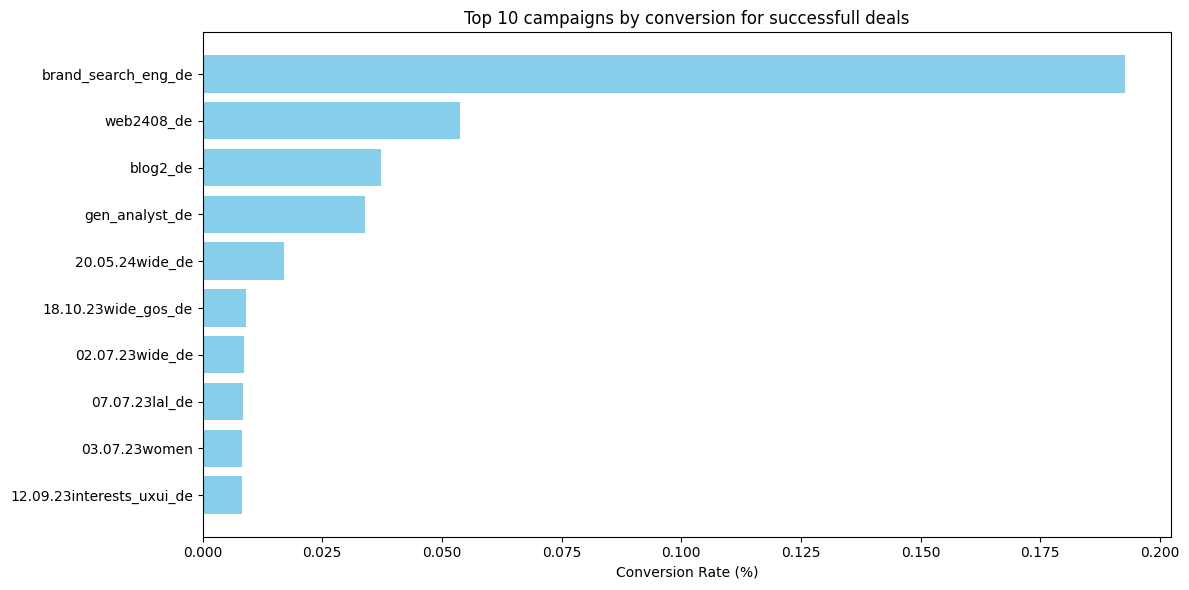

In [36]:
# visualize the top 10 campaigns by conversion for successfull deals on a graph

import matplotlib.pyplot as plt

success_top10_by_conversion = success_merged_df_sorted[success_merged_df_sorted['Conversion Rate (%)'].notna()].head(10)

plt.figure(figsize=(12,6))
plt.barh(success_top10_by_conversion['Campaign'], success_top10_by_conversion['Conversion Rate (%)'], color='skyblue')
plt.xlabel('Conversion Rate (%)')
plt.title('Top 10 campaigns by conversion for successfull deals')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

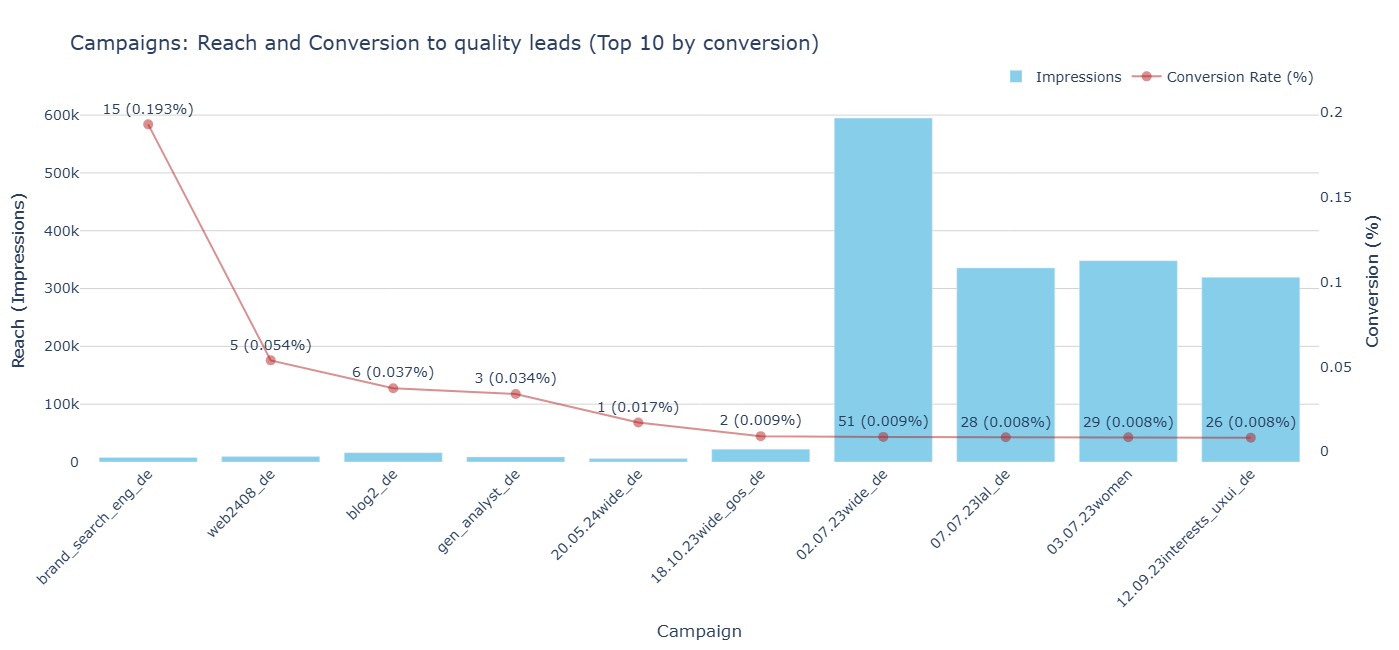

In [40]:
import plotly.graph_objects as go
import plotly.graph_objects as go

# create signatures with the number of leads and conversion percentage
texts = [f"{int(leads)} ({conv:.3f}%)" for leads, conv in zip(success_top10_by_conversion['Leads'], success_top10_by_conversion['Conversion Rate (%)'])]

fig = go.Figure()

# Bar: Impressions
fig.add_trace(go.Bar(
    x=success_top10_by_conversion['Campaign'],
    y=success_top10_by_conversion['Impressions'],
    name='Impressions',
    marker_color='skyblue',
    yaxis='y1'
))

# Line: Conversion Rate (%) 
fig.add_trace(go.Scatter(
    x=success_top10_by_conversion['Campaign'],
    y=success_top10_by_conversion['Conversion Rate (%)'],
    name='Conversion Rate (%)',
    mode='lines+markers+text',
    marker=dict(color='rgba(178,34,34,0.5)', size=10),
    line=dict(width=2, color='rgba(178,34,34,0.5)'),
    text=texts,
    textposition='top center',
    yaxis='y2'
))

fig.update_layout(
    title='Campaigns: Reach and Conversion to quality leads (Top 10 by conversion)',
    xaxis=dict(title='Campaign', tickangle=-45, showgrid=False),
    yaxis=dict(
        title='Reach (Impressions)',
        showgrid=True,
        gridcolor='lightgrey',
        zeroline=False
    ),
    yaxis2=dict(
        title='Conversion (%)',
        overlaying='y',
        side='right',
        showgrid=False,
        zeroline=False
    ),
    legend=dict(        
        orientation='h',
        yanchor='bottom',
        y=1.02,
        xanchor='right',
        x=1
    ),
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=14),
    height=650
)

fig.show()

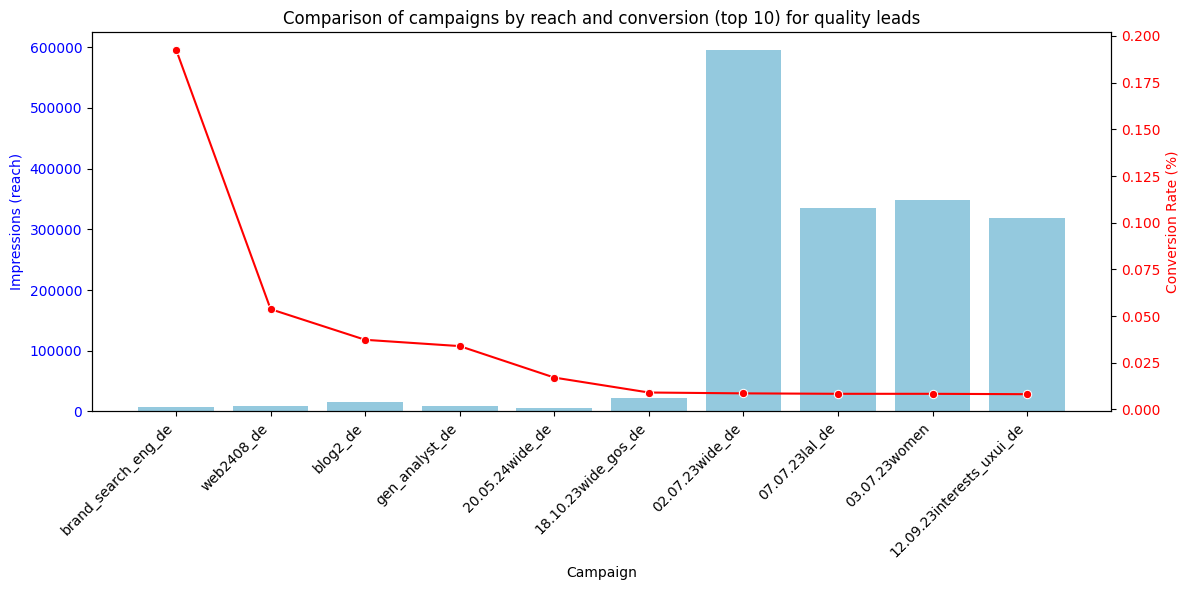

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Отсортируем по охвату (или конверсии) и возьмём топ-10 кампаний для удобства
# success_top10_by_conversion = success_merged_df_sorted.sort_values(by='Conversion Rate (%)', ascending=False).head(10).copy()

fig, ax1 = plt.subplots(figsize=(12,6))

# Bar chart for Impressions
sns.barplot(x=success_top10_by_conversion['Campaign'], y='Impressions', data=success_top10_by_conversion, ax=ax1, color='skyblue')
ax1.set_ylabel('Impressions (reach)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(len(success_top10_by_conversion)))
ax1.set_xticklabels(success_top10_by_conversion['Campaign'], rotation=45, ha='right')

# Create a second Y axis for conversion
ax2 = ax1.twinx()
sns.lineplot(x=success_top10_by_conversion['Campaign'], y='Conversion Rate (%)', data=success_top10_by_conversion, ax=ax2, color='red', marker='o')
ax2.set_ylabel('Conversion Rate (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Comparison of campaigns by reach and conversion (top 10) for quality leads')
plt.tight_layout()
plt.show()

In [28]:
contacts_df  = pd.read_pickle("contacts_cleaned.pkl")
contacts_df

,Id,Contact Owner Name,Created Time,Modified Time
0,5805028000000645014,Rachel White,2023-06-27 11:28:00,2023-12-22 13:34:00
1,5805028000000872003,Charlie Davis,2023-07-03 11:31:00,2024-05-21 10:23:00
2,5805028000000889001,Bob Brown,2023-07-02 22:37:00,2023-12-21 13:17:00
3,5805028000000907006,Bob Brown,2023-07-03 05:44:00,2023-12-29 15:20:00
4,5805028000000939010,Nina Scott,2023-07-04 10:11:00,2024-04-16 16:14:00
...,...,...,...,...
18543,5805028000056889209,Ulysses Adams,2024-06-21 12:11:00,2024-06-21 14:11:00
18544,5805028000056889351,Eva Kent,2024-06-21 13:32:00,2024-06-21 15:32:00
18545,5805028000056892018,Eva Kent,2024-06-21 10:21:00,2024-06-21 12:21:00
18546,5805028000056892055,Yara Edwards,2024-06-21 10:22:00,2024-06-21 12:23:00


In [30]:
unique_contacts_in_contacts = contacts_df['Id'].nunique()
print("Unique common contacts:", unique_contacts_in_contacts)

Unique common contacts: 18548


In [31]:
unique_contacts_in_deals = deals_df['Contact Name'].nunique()
print("Unique contacts in all deals:", unique_contacts_in_deals)

Unique contacts in all deals: 18089


In [32]:
unique_contacts_in_success_deals = successful_deals_df['Contact Name'].nunique()
print("Unique contacts in successful deals:", unique_contacts_in_success_deals)

Unique contacts in successful deals: 828


In [39]:
# Make a common sales funnel. To do this, we will combine tables by contact (Contact Name in deals_df corresponds to Id in contacts_df)
deals_with_contacts = deals_df.merge(
    contacts_df[['Id', 'Created Time']], 
    left_on='Contact Name', 
    right_on='Id',
    how='left'
)

# # Counting unique contacts (total)
# total_contacts = contacts_df['Id'].nunique()

# Count the number of contacts that have transactions
contacts_with_deals = deals_with_contacts['Contact Name'].nunique()

# count successful transactions (for example, Stage == 'Payment Done')
success_deals_with_contacts = deals_with_contacts[(deals_with_contacts['Stage'] == 'Payment Done') & (deals_with_contacts['Offer Total Amount'].notna())]['Contact Name'].nunique()

print(f"Total contacts: {unique_contacts_in_contacts}")
print(f"Contacts with deals: {contacts_with_deals}")
print(f"Successful deals: {success_deals_with_contacts}")

Total contacts: 18548
Contacts with deals: 18089
Successful deals: 828


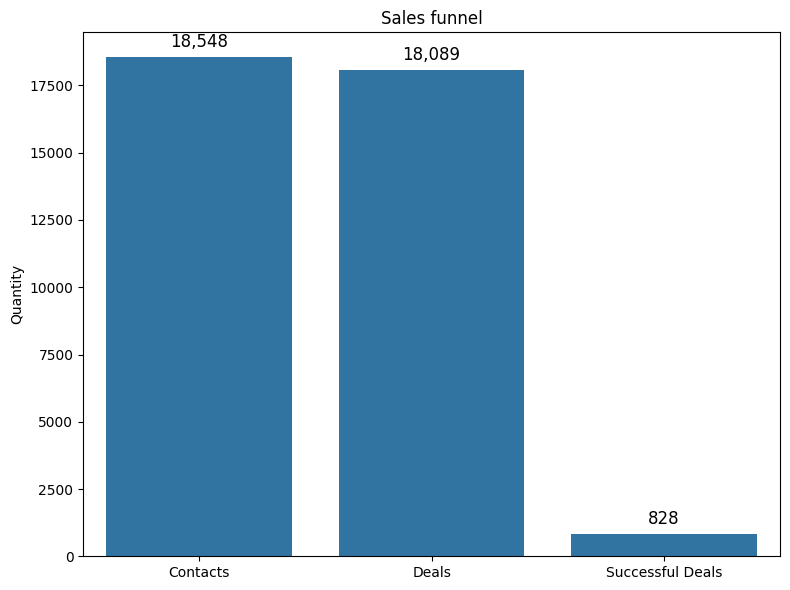

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame with funnel stages and quantities
funnel = pd.DataFrame({
    'Stage': ['Contacts', 'Deals', 'Successful Deals'],
    'Count': [unique_contacts_in_contacts, contacts_with_deals, success_deals_with_contacts]
})

# build a funnel bar chart
plt.figure(figsize=(8,6))
ax = sns.barplot(x='Stage', y='Count', data=funnel)

# add labels with quantities above the columns
for i, row in funnel.iterrows():
    ax.text(i, row['Count'] + max(funnel['Count']) * 0.02, f"{row['Count']:,}", ha='center', fontsize=12)

plt.title('Sales funnel')
plt.ylabel('Quantity')
plt.xlabel('')
plt.tight_layout()
plt.show()

In [113]:
deals_with_campaign['Campaign_y'] == 'youtube_shorts_de'

0        False
1        False
2        False
3        False
4        False
         ...  
21406    False
21407    False
21408    False
21409    False
21410     True
Name: Campaign_y, Length: 21411, dtype: bool

In [ ]:
# Add column Created Date to contacts_df without hours for correct merge with spend_df
contacts_df['Created Date'] = contacts_df['Created Time'].dt.date

In [48]:
contacts_df['Created Date'] = pd.to_datetime(contacts_df['Created Date'])

In [50]:
# Let's link the spend_df and deals_df dataframes by Id and Contact Name. Then we'll make an approximate calculation of the number of contacts 
# at the first stage of the funnel by the click dates in the spend_df dataframe and the creation date in contacts_df, since the clicks most likely 
#correspond to the contact creation date in the contacts_df table.

# Filter campaigns where there were clicks
spend_clicks = spend_df[spend_df['Clicks'] > 0][['Date', 'Campaign']]

# We remove duplicate campaign dates - leaving only one match per date
spend_clicks_unique = spend_clicks.drop_duplicates(subset=['Date'])



# Merge by date, this will give each date only one campaign
contacts_campaign = contacts_df.merge(
    spend_clicks_unique,
    left_on='Created Date',
    right_on='Date',
    how='left'
)

# check the result
print("Linked contacts to campaigns (one match per date):")
print(contacts_campaign[['Id', 'Created Date', 'Campaign']].head())

# Now we link contacts_campaign with deals_df by Id and Contact Name
deals_with_campaign = deals_df.merge(
    contacts_campaign[['Id', 'Campaign']],
    left_on='Contact Name',
    right_on='Id',
    how='left'
)

# Top 5 campaigns by number of unique contacts
top10_campaigns_by_contacts = contacts_campaign.groupby('Campaign',observed=False)['Id'].nunique().reset_index()
top10_campaigns_by_contacts = top10_campaigns_by_contacts.sort_values(by='Id', ascending=False).head(10)
print("Top 10 campaigns by common number of contacts:")
print(top10_campaigns_by_contacts)

Linked contacts to campaigns (one match per date):
                    Id Created Date               Campaign
0  5805028000000645014   2023-06-27                    NaN
1  5805028000000872003   2023-07-03  performancemax_eng_de
2  5805028000000889001   2023-07-02                    NaN
3  5805028000000907006   2023-07-03  performancemax_eng_de
4  5805028000000939010   2023-07-04                    NaN
Top 10 campaigns by common number of contacts:
                     Campaign    Id
12          12.07.2023wide_de  2656
36          youtube_shorts_de  1574
4    04.07.23recentlymoved_de  1266
2             02.07.23wide_de  1221
13  12.09.23interests_uxui_de   966
26     24.09.23retargeting_de   935
3               03.07.23women   759
7              07.07.23lal_de   721
32      performancemax_eng_de   701
29               discovery_de   599


In [54]:
#Prepare data for vizualizations

import pandas as pd
import matplotlib.pyplot as plt

# Let's prepare the final table for the funnel
funnel_data = []

for campaign in top10_campaigns_by_contacts['Campaign']:
    # campaign contacts
    campaign_contacts = contacts_campaign[contacts_campaign['Campaign'] == campaign]['Id'].unique()
    total_contacts = len(campaign_contacts)

    # deals on these contacts
    campaign_deals = deals_df[deals_df['Contact Name'].isin(campaign_contacts)]
    total_deals = campaign_deals['Contact Name'].nunique()

    # successful deals on these contacts
    successful_deals = successful_deals_df[successful_deals_df['Contact Name'].isin(campaign_contacts)]
    total_successful = successful_deals['Contact Name'].nunique()

    # Conversions
    conv_to_deal = total_deals / total_contacts * 100 if total_contacts > 0 else 0
    conv_to_payment = total_successful / total_deals * 100 if total_deals > 0 else 0

    funnel_data.append({
        'Campaign': campaign,
        'Contacts': total_contacts,
        'Deals': total_deals,
        'Successful deals': total_successful,
        'Conv_Deals_%': round(conv_to_deal, 1),
        'Conv_Payments_%': round(conv_to_payment, 1)
    })
funnel_df = pd.DataFrame(funnel_data)

# Table output
print("Conversion Funnel Table:")
print(funnel_df)

Conversion Funnel Table:
                    Campaign  Contacts  Deals  Successful deals  Conv_Deals_%  \
0          12.07.2023wide_de      2656   2592               110          97.6   
1          youtube_shorts_de      1574   1539                65          97.8   
2   04.07.23recentlymoved_de      1266   1240                58          97.9   
3            02.07.23wide_de      1221   1189                52          97.4   
4  12.09.23interests_uxui_de       966    945                53          97.8   
5     24.09.23retargeting_de       935    917                46          98.1   
6              03.07.23women       759    742                43          97.8   
7             07.07.23lal_de       721    687                24          95.3   
8      performancemax_eng_de       701    683                23          97.4   
9               discovery_de       599    590                49          98.5   

   Conv_Payments_%  
0              4.2  
1              4.2  
2              4.7  

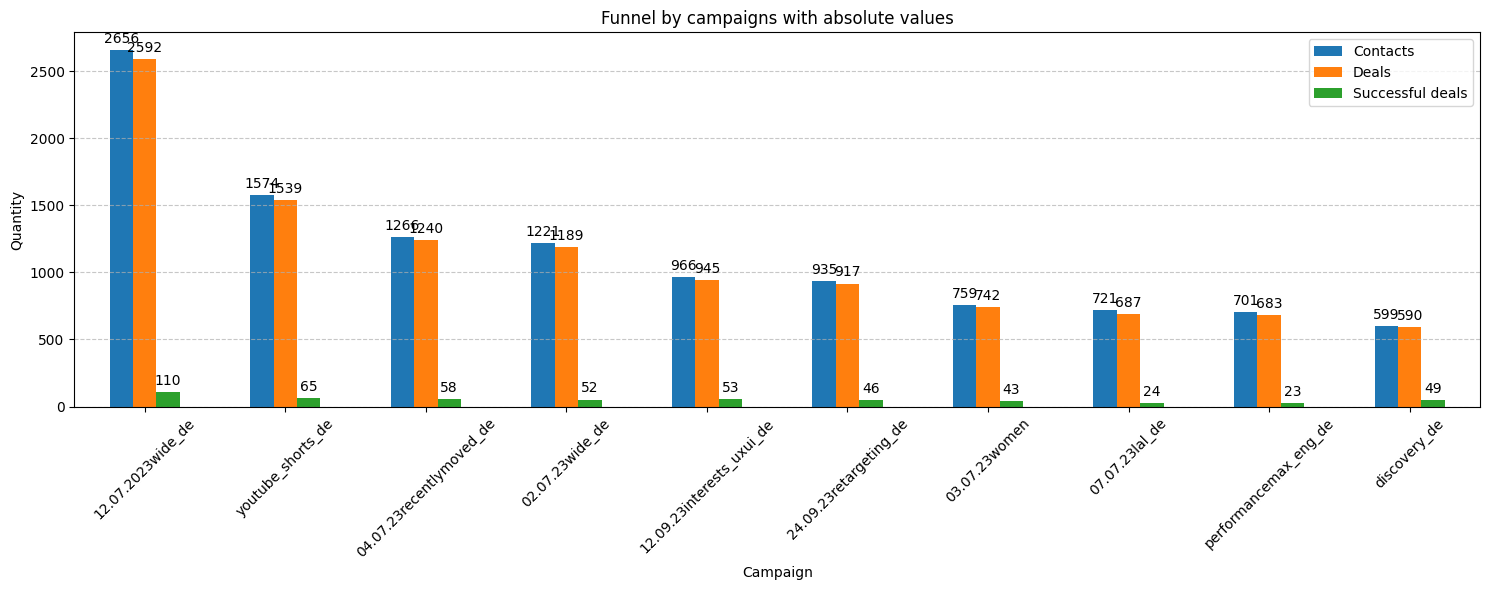

In [55]:
# Graphing
fig, ax = plt.subplots(figsize=(15, 6))
bar_plot = funnel_df.set_index('Campaign')[['Contacts', 'Deals', 'Successful deals']].plot(kind='bar', ax=ax)

ax.set_title('Funnel by campaigns with absolute values')
ax.set_ylabel('Quantity')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Let's add signatures
for container in bar_plot.containers:
    bar_plot.bar_label(container, label_type='edge', padding=3)

plt.tight_layout()
plt.show()

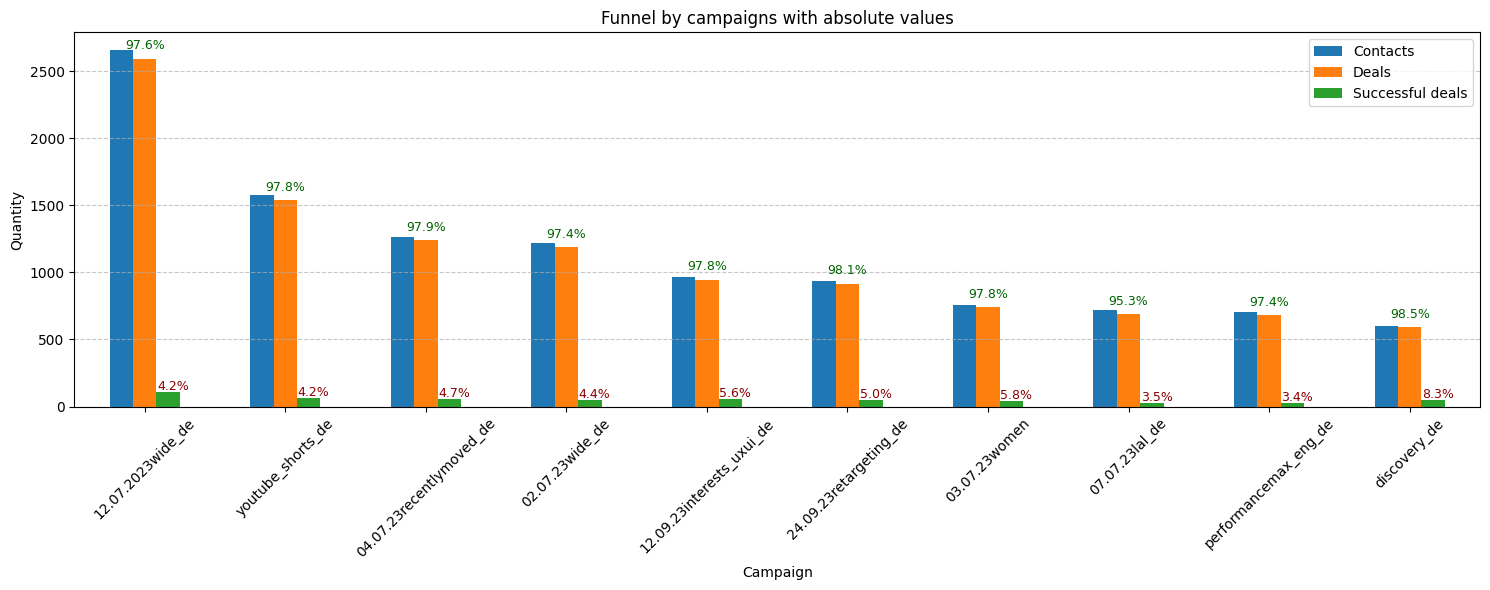

In [76]:
# Graphing
fig, ax = plt.subplots(figsize=(15, 6))
bar_plot = funnel_df.set_index('Campaign')[['Contacts', 'Deals', 'Successful deals']].plot(kind='bar', ax=ax)

ax.set_title('Funnel by campaigns with absolute values')
ax.set_ylabel('Quantity')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Let's add signatures
# for container in bar_plot.containers:
#     bar_plot.bar_label(container, label_type='edge', padding=3)

# Conversions on the bars
x_labels = funnel_df['Campaign'].tolist()
x = range(len(x_labels))

for i, row in funnel_df.iterrows():
    # The x-positions correspond to the order of the columns in each group: Contacts, Deals, Successful deals
    bar_plot.text(x[i] - 0.0001, row['Deals'] + 70, f"{row['Conv_Deals_%']}%", ha='center', fontsize=9, color='darkgreen')
    bar_plot.text(x[i] + 0.2, row['Successful deals'] +15, f"{row['Conv_Payments_%']}%", ha='center', fontsize=9, color='darkred')

plt.tight_layout()
plt.show()

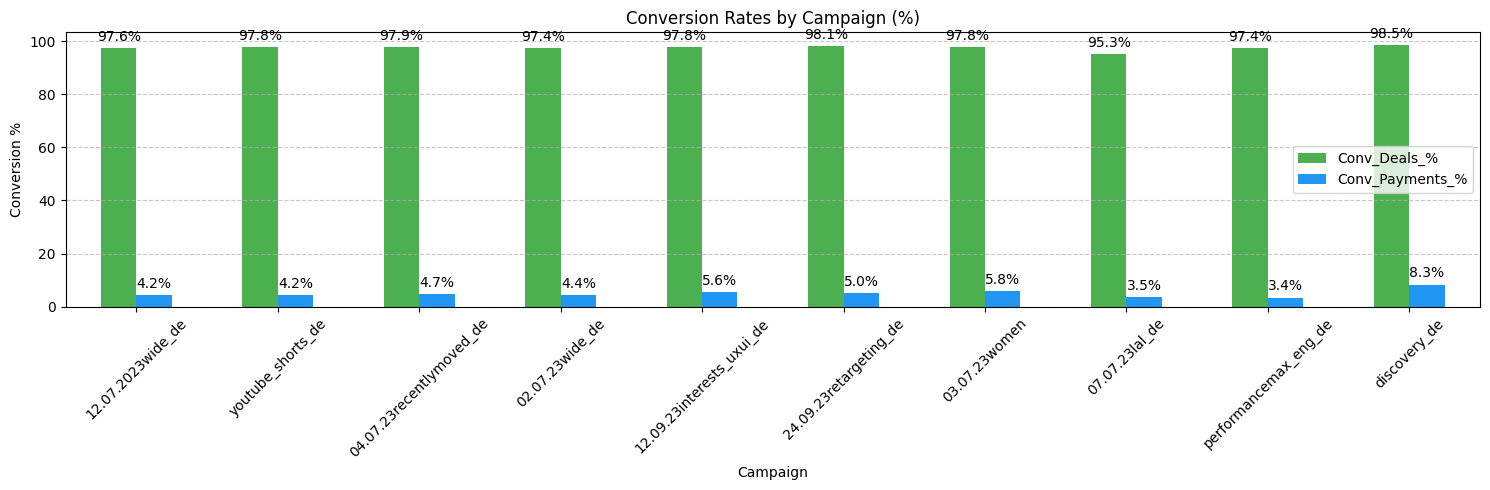

In [56]:
fig, ax = plt.subplots(figsize=(15, 5))
funnel_df.set_index('Campaign')[['Conv_Deals_%', 'Conv_Payments_%']].plot(kind='bar', ax=ax, color=['#4CAF50', '#2196F3'])

ax.set_title('Conversion Rates by Campaign (%)')
ax.set_ylabel('Conversion %')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', padding=3)

plt.tight_layout()
plt.show()

## 2. Оцените эффективность различных маркетинговых источников (Source) в генерировании качественных лидов.

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Main groupings (universal)
grouped_deals = deals_df.groupby('Source')
leads = grouped_deals['Contact Name'].nunique().rename('Leads')
total_deals = grouped_deals['Id'].count().rename('Deals')
successful_deals = deals_df[(deals_df['Stage'] == 'Payment Done') & (deals_df['Offer Total Amount'].notna())].groupby('Source')['Id'].count().rename('Successful Deals')


In [78]:
# Data for funnel
funnel_df = pd.concat([leads, total_deals, successful_deals], axis=1).fillna(0)
funnel_df = funnel_df.astype({'Leads': int, 'Deals': int, 'Successful Deals': int}).reset_index()
# Add conversion column
funnel_df['Conversion'] = (funnel_df['Successful Deals'] / funnel_df['Deals']) * 100

In [80]:
# create a copy for source_stats
source_stats = funnel_df[['Source', 'Deals', 'Successful Deals']].copy()
source_stats = source_stats.rename(columns={'Deals': 'total_deals', 'Successful Deals': 'successful_deals'})
source_stats['conversion_rate'] = (source_stats['successful_deals'] / source_stats['total_deals']) * 100
# source_stats = source_stats[source_stats['total_deals'] > 0].set_index('Source')
source_stats = source_stats[(source_stats['total_deals'] > 0) & (source_stats['conversion_rate'] > 0)]
source_stats = source_stats.set_index('Source')
print(source_stats)

                total_deals  successful_deals  conversion_rate
Source                                                        
bloggers               1087                39         3.587856
crm                    1628                23         1.412776
facebook ads           4843               196         4.047078
google ads             4197               169         4.026686
offline                   2                 0         0.000000
organic                2504               144         5.750799
partnership             203                 4         1.970443
smm                    1727                88         5.095541
telegram posts         1001                39         3.896104
test                    158                 3         1.898734
tiktok ads             2046                56         2.737048
webinar                 368                26         7.065217
youtube ads            1647                53         3.217972


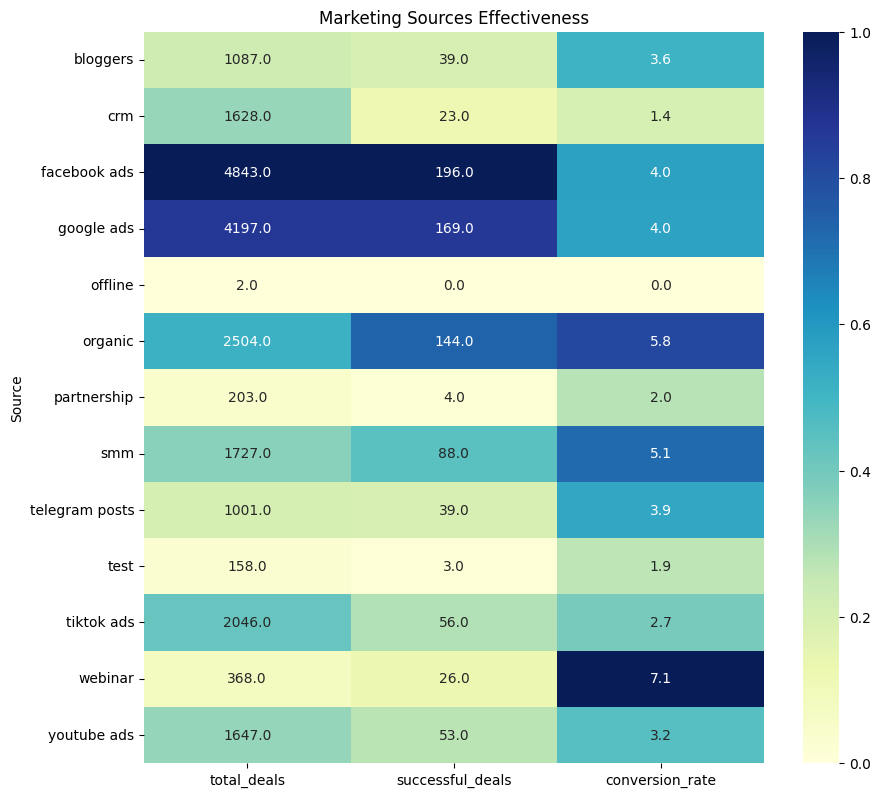

In [81]:
# visualize the obtained data on a heat map
heatmap_data = source_stats[['total_deals', 'successful_deals', 'conversion_rate']]
heatmap_norm = heatmap_data.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

plt.figure(figsize=(10, len(heatmap_data) * 0.5 + 3))
sns.heatmap(heatmap_norm, annot=heatmap_data.round(1), fmt='', cmap='YlGnBu')
plt.title('Marketing Sources Effectiveness')
plt.ylabel('Source')
plt.show()

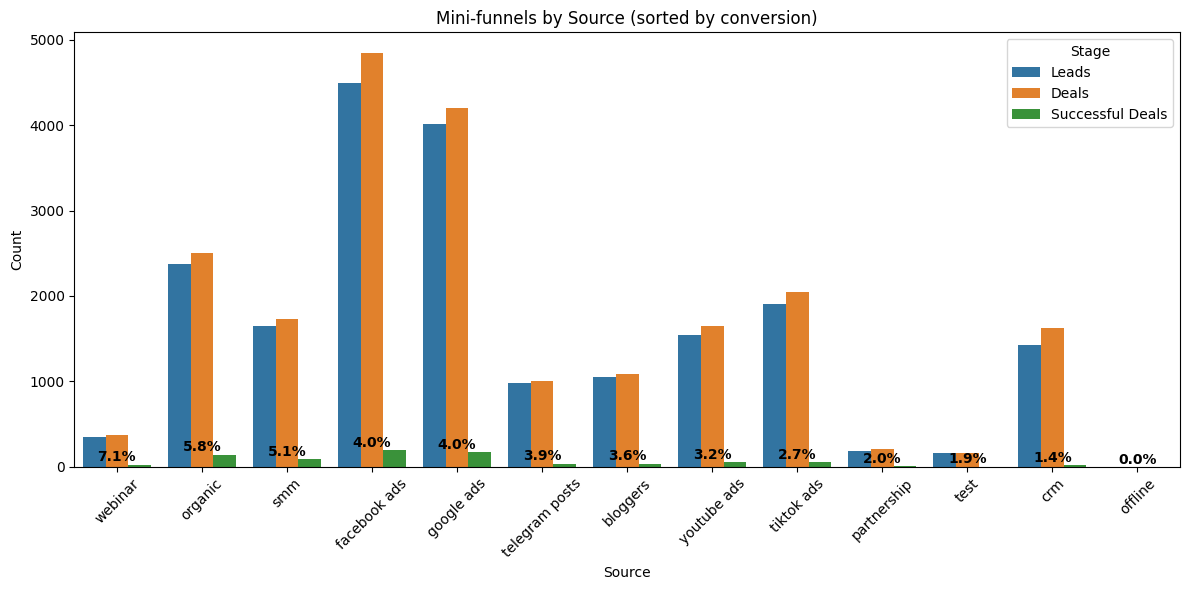

In [82]:
# visualize the obtained data on a heat map

# Sort by conversion descending
funnel_df_sorted = funnel_df.sort_values(by='Conversion', ascending=False).reset_index(drop=True)

# Transform to long format for barplot
funnel_df_melted = funnel_df_sorted.melt(id_vars='Source', value_vars=['Leads', 'Deals', 'Successful Deals'],
                                         var_name='Stage', value_name='Count')

# Create barplot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=funnel_df_melted, x='Source', y='Count', hue='Stage')

# Annotate only conversion percentage above 'Successful Deals'
for i, row in funnel_df_sorted.iterrows():
    if row['Deals'] > 0:
        ax.text(
            x=i,
            y=row['Successful Deals'] + 2,
            s=f"{row['Conversion']:.1f}%",
            ha='center',
            va='bottom',
            fontsize=10,
            color='black',
            fontweight='bold'
        )

# Plot styling
plt.title('Mini-funnels by Source (sorted by conversion)')
plt.xticks(rotation=45)
plt.xlabel('Source')
plt.ylabel('Count')
plt.tight_layout()
plt.show()